In [21]:
%matplotlib inline
import pandas as pd

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

In [22]:
df0 = pd.read_csv('heart.csv')

In [52]:
df0.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,0,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,0,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,0,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,1,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,0,0.0,Up,0


In [53]:
# Altera nomes de colunas e remove os NaNs
df1 = df0.dropna()
df = df1.rename(columns={'Age': 'idade', 'Sex': 'sexo', 'Cholesterol': 'nivel_colesterol', 'HeartDisease': 'doencas_cardiacas', 'RestingBP': 'pressao_sanguinea', 'FastingBS': 'acucar_sangue', 'MaxHR': 'frequencia_maxima' })
df.head()

,idade,sexo,ChestPainType,pressao_sanguinea,nivel_colesterol,acucar_sangue,RestingECG,frequencia_maxima,ExerciseAngina,Oldpeak,ST_Slope,doencas_cardiacas
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


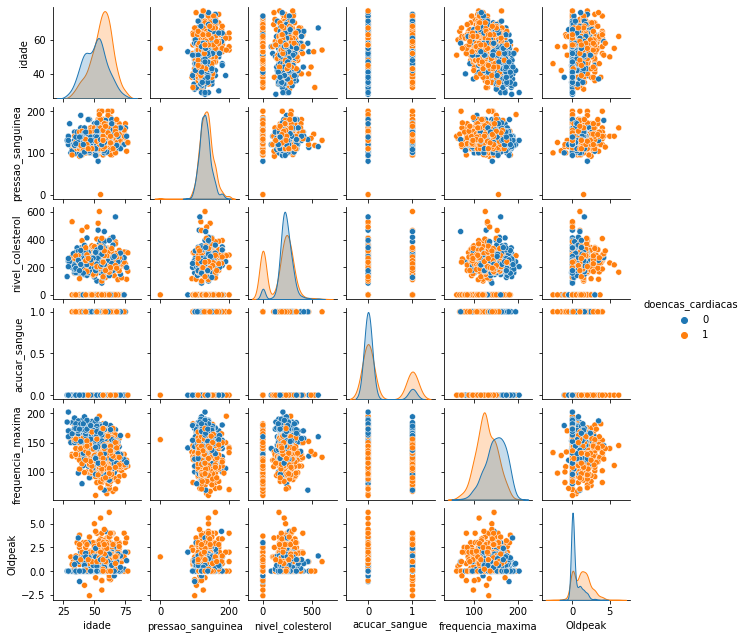

In [54]:
sns.pairplot(df, hue = 'doencas_cardiacas', height=1.5);

In [55]:
df.describe()

,idade,pressao_sanguinea,nivel_colesterol,acucar_sangue,frequencia_maxima,Oldpeak,doencas_cardiacas
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [56]:
df.isnull().sum()

idade                0
sexo                 0
ChestPainType        0
pressao_sanguinea    0
nivel_colesterol     0
acucar_sangue        0
RestingECG           0
frequencia_maxima    0
ExerciseAngina       0
Oldpeak              0
ST_Slope             0
doencas_cardiacas    0
dtype: int64

In [57]:
# separação das variáveis
X = df[['idade', 'pressao_sanguinea', 'nivel_colesterol', 'acucar_sangue', 'frequencia_maxima', 'Oldpeak']]
Y = df['doencas_cardiacas']

In [58]:
### Função utilitária para fazer a regressão com constante adicionada

def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      doencas_cardiacas   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     77.86
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.56e-78
Time:                        15:06:08   Log-Likelihood:                -471.01
No. Observations:                 918   AIC:                             956.0
Df Residuals:                     911   BIC:                             989.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0703      0.157      6.828      0.000       0.763       1.378
idade                 0.0020      0.002      1.236      0.217      -0.001       0.005
pressao_sanguinea     0.0003      0.001      0.437      0.662      -0.001       0.002
nivel_colesterol     -0.0006      0.000     -4.805      0.000      -0.001      -0.000
acucar_sangue         0.1979      0.033      5.923      0.000       0.132       0.263
frequencia_maxima    -0.0054      0.001     -9.131      0.000      -0.007      -0.004
Oldpeak               0.1614      0.013     12.272      0.000       0.136       0.187
==============================================================================
Omnibus:                       46.666   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.105
Skew:                           0.049   Prob(JB):                     7.10e-05
Kurtosis:                       2.300   Cond. No.                     3.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""